In [1]:
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import matplotlib.pyplot as plt
# sys.path

importación glob
importar pandas como pd
importar numpy como np

# Llenado de valores faltantes

**Objetivo**: El objetivo de esta sección es mostrar algunas de las técnicas que pueden ser usadas para rellenar datos faltantes. En este caso de estudio abordaremos los métodos `fillna` e `interpolate` de la librería `pandas`.

## Calidad del aire de Beijing

El caso de estudio se centra en un conjunto de datos de la siguiente publicación

- \[1\] [Zhang, S., Guo, B., Dong, A., He, J., Xu, Z. and Chen, S.X. (2017) Cautionary Tales on Air-Quality Improvement in Beijing. Proceedings of the Royal Society A, Volume 473, No. 2205, Pages 20170457.](https://royalsocietypublishing.org/doi/pdf/10.1098/rspa.2017.0457)

Disponible en el repositorio de [UCI](https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data)

Las columnas incluidas en este conjunto de datos son las siguientes:

- No: número de fila
- year: año de datos en esta fila
- month: mes de datos en esta fila
- day: día de datos en esta fila
- hour: hora de datos en esta fila
- PM2.5: concentración de PM2.5 (ug / m ^ 3)
- PM10: concentración de PM10 (ug / m ^ 3)
- SO2: concentración de SO2 (ug / m ^ 3)
- NO2: concentración de NO2 (ug / m ^ 3)
- CO: concentración de CO (ug / m ^ 3)
- O3: concentración de O3 (ug / m ^ 3)
- TEMP: temperatura (grado Celsius)
- PRES: presión (hPa)
- DEWP: temperatura de rocío (grados Celsius) - temperatura de rocío es la más alta temperatura a la que empieza a condensarse el vapor de agua contenido en el aire.
- RAIN: precipitación (mm)
- wd: dirección del viento
- WSPM: velocidad del viento (m / s)
- station: nombre del sitio de monitoreo de la calidad del aire

Las estaciones están todas ubicadas en el área metropolitana de Beijing. En la siguiente figura los puntos violetas muestran su ubicación, los triángulos son estaciones meteorológicas y los puntos rojos son otras estaciones no incluidas en el conjunto de datos. Las lineas azul y naranjas fividen a la metropolis en zona norte, centro y sur.     

<img src="img/Beijing_AQ.png" style='width:600px'>
<center><b>Figura 1:</b> Ubicación de las estaciones de monitoreo - Fuente [1].</center>

**Consolidar conjunto de datos**  
En primer lugar cargamos el conjunto de datos en memoria. Cada csv contiene las series de tiempo con frecuencia horaria de las 12 estaciones mencionadas, para 4 años calendario, desde marzo 2013 hasta febrero 2017. Por este motivo, todos los archivos tienen la misma cantidad de filas y columnas.

Para trabajar todo el conjunto de datos en un solo archivo, construimos un `DataFrame` con un multiíndice en las columnas. En el primer nivel usaremos el nombre de la estación y en la segunda las variables anteriormente descritas. 

In [2]:
# contruye una lista con las rutas de los archivos csv a cargar
rutas_csv = sorted(glob.glob('data_UCI/PRSA_Data_20130301-20170228/*'))

# inicializa el diccionario que contendra los DataFrame de cadad estacion
df_dict = {}

for csv_p in rutas_csv:
    
    # reporta el archivo cargado y su numero de filas y columas
    print(f'cargando el archivo: {csv_p}')
    df_ = pd.read_csv(csv_p, index_col=0)
    print(f'shape: {df_.shape}\n')
    
    # obten el nombre de la estacion ara usarla como llave del diccionario
    estacion_arreglo = df_.station.unique()
    estacion_name = estacion_arreglo[0]

    df_dict[estacion_name] = df_

# construye el DataFrame consolidado 
baq_df = pd.concat(df_dict, axis=1)
baq_df

ValueError: No objects to concatenate

**Contar número de valores nulos**  
Para mostrar las diferentes maneras de llenado de valores faltantes primero estudiaremos la cantidad de valores nulos que presentan los datos.

In [ ]:
# cuenta el numero de valores nulos y agrupa por columna en el segundo nivel
grupo = baq_df.isnull().sum().groupby(level=1, sort=False)

# suma los valos nulos de cada grupo
n_nulos = grupo.sum()

# reporta los resultados en numero absoluto y porcentaje 
df_nulos = pd.concat([n_nulos, n_nulos * 100 / (len(df_dict) * baq_df.shape[0])],
                     keys=['n_nulos', 'porcentaje'], axis=1)
df_nulos

**Contar la cantidad máxima de valores nulos contiguos**  
Además de contar la cantidad de nulos, dado que se trata de series de tiempo, nos interesa saber la cantidad máxima de valores nulos contiguos.

In [ ]:
def encontrar_max_contiguo(srs):
    '''
    Encuentra la maxima suma de `1` adyacentes en una
    en un `iterable` de `0` y `1`
    
    Parametros
    ----------
    srs : iterable,
        compuesto solo por elementos `0` o `1`.
        
    Retorna
    -------
    max : int,
        el numero maximo de `1` contiguos
    '''
    
    # inicializa valores maximos
    max_ = 0
    contiguo_max = 0
    
    # recorre los
    for a in srs:
        if a != 0:
            contiguo_max += a
            if max_ < contiguo_max:
                max_ = contiguo_max
        else:
            contiguo_max = 0
    return max_

In [ ]:
# calcula cantidad maxima de valores nulos contiguos en las
# columnas que presentan valores nulos
nulos_contiguos = baq_df.isnull().loc[:, baq_df.isnull().any(0)].apply(encontrar_max_contiguo)
nulos_contiguos

In [ ]:
# calcula  el promedio de nulos contiguos por variable
grupo_nulos_contiguos = nulos_contiguos.groupby(level=1, sort=False)
grupo_nulos_contiguos.describe()

### Método `fillna`
Para las columnas en las que el porcentaje de nulos es menor al 1% llenaremos los valores faltantes con métodos simples que están disponibles en el método `fillna`. Además, en estas columnas los valores faltantes consisten en a lo más un periodo de 13 horas y en su mayoría no sobrepasa las 6 horas corridas (ver celda anterior).

In [ ]:
# este objeto sera util para trabajar con índices multiples
idx = pd.IndexSlice

# muestra en pantalla las variables que presentan valores nulos menores al 1%
df_nulos.index[(df_nulos['porcentaje'] < 1) & (df_nulos['porcentaje'] > 0)]

**Llenado con una constante**  
Para la variable `'RAIN'` asumiremos arbitrariamente que si el valor es nulo, se debe a ausencia de lluvia

In [ ]:
# muestra en pantalla las filas con valores nulos
col_a_llenar = 'RAIN'
filas_con_nulos = baq_df.loc(axis=1)[:, col_a_llenar].isnull().any(1)
baq_df.loc[filas_con_nulos, idx[:, col_a_llenar]]

In [ ]:
# rellena los valores nulos
baq_df.loc(axis=1)[:, col_a_llenar] = baq_df.loc(axis=1)[:, col_a_llenar].fillna(0)
baq_df.loc[filas_con_nulos, idx[:, col_a_llenar]]

**Llenado con la moda**  
Para nuestra única variable categórica, `'wd'` (dirección del viento). 

In [3]:
# muestra en pantalla las filas con valores nulos
col_a_llenar = 'wd'
filas_con_nulos = baq_df.loc(axis=1)[:, col_a_llenar].isnull().any(1)
baq_df.loc[filas_con_nulos, idx[:, col_a_llenar]]

NameError: name 'baq_df' is not defined

In [ ]:
# calcula la moda por columna
moda_wd = baq_df.loc(axis=1)[:, col_a_llenar].mode()
moda_wd.iloc[0]

In [4]:
# rellena los valores nulos
baq_df.loc(axis=1)[:, col_a_llenar] = baq_df.loc(axis=1)[:, col_a_llenar].fillna(
    moda_wd.iloc[0], axis=0)
baq_df.loc[filas_con_nulos, idx[:, col_a_llenar]]

NameError: name 'baq_df' is not defined

**Llenado con la mediana**  
Para la columna `'WSPM'` (velocidad del viento). 

In [ ]:
# muestra en pantalla las filas con valores nulos
col_a_llenar = 'WSPM'
filas_con_nulos = baq_df.loc(axis=1)[:, col_a_llenar].isnull().any(1)
baq_df.loc[filas_con_nulos, idx[:, col_a_llenar]]

In [5]:
# calcula la mediana por columna
mediana_wspm = baq_df.loc(axis=1)[:, col_a_llenar].median()
mediana_wspm

NameError: name 'baq_df' is not defined

In [ ]:
# rellena los valores nulos
baq_df.loc(axis=1)[:, col_a_llenar] = baq_df.loc(axis=1)[:, col_a_llenar].fillna(
    mediana_wspm, axis=0)
baq_df.loc[filas_con_nulos, idx[:, col_a_llenar]]

**Llenado con el promedio**  
Para las columna `'PRES'` (presión).

In [6]:
# muestra en pantalla las filas con valores nulos
col_a_llenar = 'PRES'
filas_con_nulos = baq_df.loc(axis=1)[:, col_a_llenar].isnull().any(1)
baq_df.loc[filas_con_nulos, idx[:, col_a_llenar]]

NameError: name 'baq_df' is not defined

In [7]:
# calcula la moda por columna
promedio_pres = baq_df.loc(axis=1)[:, col_a_llenar].mean()
promedio_pres

NameError: name 'baq_df' is not defined

In [ ]:
# rellena los valores nulos
baq_df.loc(axis=1)[:, col_a_llenar] = baq_df.loc(axis=1)[:, col_a_llenar].fillna(
    promedio_pres, axis=0)
baq_df.loc[filas_con_nulos, idx[:, col_a_llenar]]

**Llenado con métodos `'ffill'` y `'bfill'`**  

El método `fillna` tiene dos métodos que son útiles para DataFrame's donde que dos valores sean contiguos implica alguna noción de proximidad. En el caso de estudio, al tratarse de series de tiempo, dos valores contiguos  ocurren cerca el espacio temporal. Estos métodos son:
1. Llenado hacia adelante (`'ffill'`): donde el último valor no nulo es propagado hacia adelante
2. Llenado hacia atrás (`'bfill'`): donde los valores nulos son reemplazados por el siguiente valor no nulo.
  
<bk>  
    
- Así, para la columna `'Temp'` (temperatura), usaremos el método de llenado hacia adelante

In [8]:
# muestra en pantalla las filas con valores nulos
col_a_llenar = 'TEMP'
filas_con_nulos = baq_df.loc(axis=1)[:, col_a_llenar].isnull().any(1)
baq_df.loc[filas_con_nulos, idx[:, col_a_llenar]]

NameError: name 'baq_df' is not defined

In [ ]:
# rellena los valores nulos
baq_df.loc(axis=1)[:, col_a_llenar] = baq_df.loc(axis=1)[:, col_a_llenar].fillna(
    method='ffill')
baq_df.loc[filas_con_nulos, idx[:, col_a_llenar]]

- Por su parte para la columna `'DEWP'`, usaremos el método de llenado hacia atrás.

In [9]:
# muestra en pantalla las filas con valores nulos
col_a_llenar = 'DEWP'
filas_con_nulos = baq_df.loc(axis=1)[:, col_a_llenar].isnull().any(1)
baq_df.loc[filas_con_nulos, idx[:, col_a_llenar]]

NameError: name 'baq_df' is not defined

In [ ]:
# rellena los valores nulos
baq_df.loc(axis=1)[:, col_a_llenar] = baq_df.loc(axis=1)[:, col_a_llenar].fillna(
    method='bfill')
baq_df.loc[filas_con_nulos, idx[:, col_a_llenar]]

**Comprobar el procedimiento**  
Ahora que ya hemos llenado los valores nulos de todas las columnas que presentaban un porcentaje menor a 1%, comprobemos que esto se ha ejecutado satisfactoriamente, calculando nuevamente los valores faltantes por columna.

In [10]:
# cuenta el numero de valores nulos y agrupa por columna en el segundo nivel
grupo_despues_fillna = baq_df.isnull().sum().groupby(level=1, sort=False)

# suma los valos nulos de cada grupo
n_nulos_despues_fillna = grupo_despues_fillna.sum()

# reporta los resultados en numero absoluto y porcentaje 
df_nulos_despues_fillna = pd.concat([n_nulos_despues_fillna, n_nulos_despues_fillna * 100 / (len(df_dict) * baq_df.shape[0])],
                     keys=['n_nulos', 'porcentaje'], axis=1)
print('antes fillna'); display(df_nulos)
print('\n\ndespues fillna'); display(df_nulos_despues_fillna)

NameError: name 'baq_df' is not defined

### Método `interpolate`
Los valores que faltantes restantes, serán rellenados mediante el método `interpolate` (su nombre es autoexplicativo).
- Se podría estudiar cual es la interpolación que tiene mejor fit con cada una de los contaminantes. (**Ejercicio?:** 80, 20 para train y test y medida de performance RMSE.)


In [11]:
test_df = baq_df.loc[:, baq_df.isnull().any(0)].copy()

NameError: name 'baq_df' is not defined

In [ ]:
test_df.interpolate(method='linear')

# BREAK
# NO INCLUIR (Puede servir de base para MOGP)
El objetivo de la publicación \[1\] [Zhang, S., Guo, B., Dong, A., He, J., Xu, Z. and Chen, S.X. (2017) Cautionary Tales on Air-Quality Improvement in Beijing. Proceedings of the Royal Society A, Volume 473, No. 2205, Pages 20170457.](https://royalsocietypublishing.org/doi/pdf/10.1098/rspa.2017.0457) es calcular el promedio de PM2.5 en el año 2017.  
- se puede estudiar el modelo de regresión propuesto en el paper
- se puede usar MOGP para calcular dicho promedio, tomando la esperanza en el área de la ciudad completa y con un intervalo de confianza. 

In [12]:
estacion_max_nul = baq_df.isnull().groupby(axis=1, level=0).sum().sum().idxmax()

NameError: name 'baq_df' is not defined

In [ ]:
# df = baq_df.xs(estacion_max_nul, axis=1, level=0).copy()
df = df_dict[estacion_max_nul]
display(df)

**Verificar que se tienen 4 años de datos**

In [13]:
columnas_temp = ['year', 'month', 'day', 'hour']
for ct in columnas_temp:
    print(f'\nvalue counts para columna {ct}')
    display(df[ct].value_counts(sort=False).sort_index())


value counts para columna year


NameError: name 'df' is not defined

**Visualizar la distribución de los valores nulos**

In [ ]:
nulos_df = df.loc[:, df.isnull().any(0)]

NameError: name 'nulos_df' is not defined

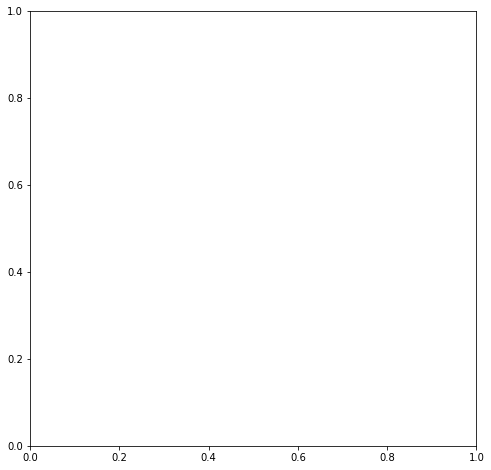

In [14]:
plt.subplots(figsize=(8, 8))
sns.heatmap(~ nulos_df.isnull(), cbar=False)
plt.title('Matriz de presencia de nulos');

In [ ]:
# Calcular matriz de correlación de presencia de nulos
nulos_corr = nulos_df.isnull().corr()

def dibuja_matriz_de_correlación(corr_df):
    '''Funcion personalizada para dibugjar la priz de correlación'''
    sns.set(style="white", font_scale=1.25)

    # Generar una mascara para el triangulo superior
    mascara = np.triu(np.ones_like(corr_df.values, dtype=np.bool))

    # Iniciaizar fugura para configurar tamanño
    f, ax = plt.subplots(figsize=(10, 8))

    # Generar un colormap apropiado
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Dibujar matriz de correlación
    sns.heatmap(corr_df.values, mask=mascara, cbar=True, cmap=cmap, vmin=-1, vmax=1,
                annot=True, square=True, fmt='.2f', linewidths=.5, 
                cbar_kws={"shrink": .5}, yticklabels=corr_df.columns.values, 
                xticklabels=corr_df.columns.values)
    

dibuja_matriz_de_correlación(nulos_corr)
plt.title('Correlación de la matriz de presencia de nulos')

La matriz nos indica la cuan fuertemente la presencia o ausencia de una variable afecta la presencia de la otra.  
- si dicha correlación es cercana a 1, la presencia de una variable *asegura* la presencia de la otra.
- si es cercana a -1, la presencia de una variable *asegura* la ausencia de la otra
- si es cercana a 0, la presencia de una variable no tiene relación con la presencia de la otra.

Así da la impresión que los censores fuertemente relacionados en cuanto a presencia de valores faltantes son:
1. Sensores de tempreatura, presión, temperatura de rocío y velocidad del viento.
2. Los sensores de PM10 y PM2.5
3. Los sensores de CO y NO2

En cuanto a correlaciones de presencia de valores faltantes de mediana intensidad:

1. Los sensores de contaminantes entre ellos con excepción de los pares mencionados arriba.
2. El sensor de dirección de viento con el sensor de velocidad del viento.

Además podemos inferir gracias al rectángulo gris que la presencia de valores faltantes en los censores de los contaminantes (PM2, PM10, SO2, NO2, CO y O3) no tiene relación con la presencia de valores faltantes en los de condiciones atmosféricas (el resto de variables). 

Nos podríamos preguntar si esa última observación también se observa en la matriz de correlación de los valores observados en dichas variables

In [ ]:
# Calcular matriz de correlacion
corr = nulos_df.corr()

# dibuja matriz de correlación
dibuja_matriz_de_correlación(corr)
plt.title('Matriz de correlacion')

Ahora podemos observar que existe una correlación importante entre la mayoría de los contaminantes, excepto el ozono (O3), que por suparte presenta una correlación importante con la temperatura.
- Propongo hacer un MOGP con los contaminantes y la temperatura

# NO INCLUIR
**Estudio de nulos valores de temperatura**

In [ ]:
temp_df = pd.concat(df_dict, axis=1).xs('TEMP', axis=1, level=1)
plt.subplots(figsize=(8, 8))
sns.heatmap(temp_df.isnull(), cbar=False, linewidth=0)
plt.title('Matriz de presencia de nulos: columnas `TEMP`');

In [15]:
plot_srs = temp_df.isnull().sum()
plot_srs.plot(kind='bar', color='grey')
for i, patch in enumerate(plt.gca().patches):
    
    # obtener coordenadas y medidas
    x = patch.get_x()
    h = patch.get_height()
    w = patch.get_width()
    
    # adjuntar texto con valores de cada barra
    plt.annotate(f'{plot_srs.iloc[i]}', xy=(x + w / 2, h), ha='center', va='bottom')
    
plt.ylim([1.1 * y_ for y_ in plt.gca().get_ylim()])

NameError: name 'temp_df' is not defined

In [ ]:
dibuja_matriz_de_correlación(temp_df.isnull().corr())
plt.title('Correlación de la matriz de presencia de nulos en TEMPERATURA')

# Expresiones regulares
Limpieza de texto con expresiones regulares.

## Datos de Twitter
La [Competencia Kaggle: Twitter Sentiment Extraction](https://www.kaggle.com/c/tweet-sentiment-extraction) está actualmente en linea (el premio es 15 mil dólares!) y se trata de encontrar es substring del tweet que contiene el sentimiento del tweet completo.

El objetivo de este pequeño ejercicio es simplemente dar una introducción a las **expresiones regulares**, ya que son muy útiles como herramienta para la limpieza de texto.

**Importar librerias**  
La librería para el uso de expresiones regulares en Python es `re`.

In [16]:
# import re
import string 

**Cargar datos**  
El conjunto de datos de entrenamiento tiene 4 columnas:
- textID: indetificar del tweet
- text: contenido del tweet
- selected_text: extracto del tweet que expresa el sentimiento
- sentiment: sentimiento del tweet. Puede ser `'negative'`,`'neutral'`,`'positive'`

Naturalmente, las columnas que nos interesan limpiar son `'text'`y `'selected_text`. 

In [17]:
ruta_tse_entrenamiento = 'data_kaggle/twitter/train.csv'
tse_df = pd.read_csv(ruta_tse_entrenamiento)

In [18]:
tse_df

,textID,text,selected_text,sentiment
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,neutral
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,neutral
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,negative
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive
...,...,...,...,...
27481,3dbae74fcd,"I want to go to VP, but no one is willing to c...","I want to go to VP, but no one is willing to c...",neutral
27482,63147b35cb,"Wah, why are you sad?","Wah, why are you sad?",neutral
27483,bdb196a09f,playing sudoku while mommy makes me breakfast ...,playing sudoku while mommy makes me breakfast ...,neutral
27484,18c2a1e98e,see u bye see u! i love the hot30,i love,positive


In [19]:
srs = tse_df['text']

- convertir el texto en minúsculas

In [20]:
srs = srs.str.lower()
srs

0        spent the entire morning in a meeting w/ a ven...
1            oh! good idea about putting them on ice cream
2        says good (or should i say bad?) afternoon!  h...
3               i dont think you can vote anymore! i tried
4                   haha better drunken tweeting you mean?
                               ...                        
27481    i want to go to vp, but no one is willing to c...
27482                                wah, why are you sad?
27483    playing sudoku while mommy makes me breakfast ...
27484                   see u bye see u!  i love the hot30
27485           ha ha, and what game is that? i like games
Name: text, Length: 27486, dtype: object

In [21]:
def eliminar_con_regex(srs, regex, verbose=True):
    '''Funcion personalizada para eliminar texto de la serie `srs` 
    mediante la expresión regular `regex`.
    '''
    
    if verbose:
        
        # encunetra filas que coinciden con la expresión regular
        bools_ = srs.str.contains(regex, na=False)
        
        # reporta las filas que tienen coincidencia 
        print('antes de eliminar:')
        display(srs[bools_])
    
    # elimina el substring
    ret = srs.str.replace(regex, '')
    
    if verbose:
        
        # reporta las filas que tienen coincidencia 
        print('\n\ndespues de eliminar:')
        display(ret[bools_])
        
    return ret

- quitar texto entre paréntesis cuadrados, pues estos son usados para denotar un lugar geolocalizado. Para esto usamos la expresión regular `'\[.*?\]'`. Esta está compuesta por:
    - `'\['` y `\]` que denotan simplemente los caracteres `'['` y `']'`. Esto debido a que para las expresiones regulares, todos los carácteres hacen coincidencia con si mismos salvo `'+'`, `'?'`, `'.'`, `'*'`, `'^'`, `'$'`, `'('`, `')'`, `'['`, `']'`, `'{'`, `'}'`, `'|'` y `'\'` que son caracteres especiales.
    - `'.'` que denota cualquier carácter, excepto la nueva línea.
    - `'*'` es un cuantificador de 0 o más ocurrencias de la expresión precedente. Cunado un cuantificador es sucedido por un `'?'` se transforma en un cuantificado flojo, lo que implica que a penas la expresión regular completa haga coincidencia, no seguirá buscando otra que la contenga. Por ejemplo en el string `'10100000100'` la expresión regular `'1.*?1'` entregara el substring `'101'` como coincidencia. Por su parte, con la expresión regular `'1.*1'` entregará `'101000001'`  
    
  Por lo tanto, la expresión denota cualquier texto entre paréntesis cuadrados que no contenga un salto de línea.
  

In [22]:
srs = eliminar_con_regex(srs, '\[.*?\]');

antes de eliminar:


1798      rt/westcoastgal88 - it's the facial hair, the...
1971      i's sorry  listen to some bats or gd as you d...
2063                               im bored   -musiic[box]
2077     [stapler haiku] whar a night! woo hoo! yeah! /...
2221     [bbc] malaria parasites becoming resistant to ...
4264     [ i'm not sure what you mean by &quot;blowin t...
4563      hey!  who are you closest to among all the di...
4781     [wrong!] #liesboystell your the only one, i lo...
5245     [somewhere - within temptation] returned to my...
5789     [-o] i wish the birthday massacre would come t...
7930     [wrong!]  thanx  your the awesome! http://tiny...
8829     night night twitter world. [still cant believe...
10663    [dashboard - modest mouse] first modest mouse ...
10832    yesterday was fun.. 1st concert of the year [i...
10934     &quot;phlegmily green house...&quot; that was...
11203    [aeroplanes - we know, plato!] one of my favor...
11268    new blog post: [blog] auto insuran...: i just .



despues de eliminar:


1798      rt/westcoastgal88 - it's the facial hair, the...
1971      i's sorry  listen to some bats or gd as you d...
2063                                    im bored   -musiic
2077      whar a night! woo hoo! yeah! / a beautiful ni...
2221      malaria parasites becoming resistant to drugs...
4264      rb lol lol good one......  ? http://blip.fm/~...
4563      hey!  who are you closest to among all the di...
4781      #liesboystell your the only one, i love (they...
5245       returned to mysefl. keep working hard till june
5789      i wish the birthday massacre would come to au...
7930       thanx  your the awesome! http://tinyurl.com/...
8829                           night night twitter world. 
10663     first modest mouse blip! oyay, not bad.  ? ht...
10832    yesterday was fun.. 1st concert of the year .....
10934     &quot;phlegmily green house...&quot; that was...
11203     one of my favorite wkp songs!  ? http://blip....
11268    new blog post:  auto insuran...: i just found .

- Eliminar los links: Para ello se usa la expresión regular `'https?://\S+|www\.\S+'` que está compuesta por:
    - `'?'` es un cuantificador que acepta 0 o 1 ocurrencia de la expresión regular que la antecede. En este caso 0 o 1 ocurrencias de `'s'`.
    - `'\S'` coincide con todo caracter que no sea espacio (i.e. `'\t'`, `'\r'`, `'\n'` o `'\f'`)
    - `'+'` es un cuantificador que acepta 1 o más ocurrencias de la expresión regular que la antecede (patricularmente `'\S'`)
    - `'|'` denota un **o**, es decir `'https?://\S+'` **o** `'www\.\S+'`
    - `'\.'` denota `'.'`, pues este es un carácter especial. Podemos inferir que `'\'` se usa como carácter de escape.

In [23]:
srs = eliminar_con_regex(srs, 'https?://\S+|www\.\S+');

antes de eliminar:


2        says good (or should i say bad?) afternoon!  h...
56       is missing someone.. haayy..  http://plurk.com...
95        http://twitpic.com/66r0u - uh wait...i though...
120      photo: novusnovendo: eyecandy + live = like a ...
148      epsilon greater than zero misses her mommy.  h...
                               ...                        
27412     http://twitpic.com/4jbba - ohhh someone likes...
27425    says from now it will be impossible to plurk f...
27427    shares i miss my niece and nephew. http://tiny...
27440    http://twitpic.com/66uor - went on a really lo...
27469    save me--i feel like i'm going crazy.  ? http:...
Name: text, Length: 1283, dtype: object



despues de eliminar:


2            says good (or should i say bad?) afternoon!  
56                          is missing someone.. haayy..  
95         - uh wait...i thought this was the 29th...to...
120      photo: novusnovendo: eyecandy + live = like a ...
148          epsilon greater than zero misses her mommy.  
                               ...                        
27412      - ohhh someone likes to play with their food...
27425    says from now it will be impossible to plurk f...
27427                 shares i miss my niece and nephew.  
27440     - went on a really long cycle ride with my mu...
27469            save me--i feel like i'm going crazy.  ? 
Name: text, Length: 1283, dtype: object

- Eliminar todos los caracteres de puntuación. Para ellos usamos el atributo `punctuation` de la libreria `string`. Además se usan los carácteres especiales `'['` y `']'` que permiten especificar todos los posibles valores que puede tomar un carácter para coincidir con la expresión regular, así `'[python]'` es una expresión regular que coincide con los caracteres `'h'`,  `'n'`, `'o'`, `'p'`, `'t'` o `'y'`.  Notamos también que no es necesario usar el carácter de escape excepto para `'['` y `']'` para los demás caracteres especiales.

In [24]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [25]:
srs = eliminar_con_regex(srs, f'[{punctuation}]');

antes de eliminar:


0        spent the entire morning in a meeting w/ a ven...
1            oh! good idea about putting them on ice cream
2            says good (or should i say bad?) afternoon!  
3               i dont think you can vote anymore! i tried
4                   haha better drunken tweeting you mean?
                               ...                        
27481    i want to go to vp, but no one is willing to c...
27482                                wah, why are you sad?
27483    playing sudoku while mommy makes me breakfast ...
27484                   see u bye see u!  i love the hot30
27485           ha ha, and what game is that? i like games
Name: text, Length: 23445, dtype: object



despues de eliminar:


0        spent the entire morning in a meeting w a vend...
1             oh good idea about putting them on ice cream
2                says good or should i say bad afternoon  
3                i dont think you can vote anymore i tried
4                    haha better drunken tweeting you mean
                               ...                        
27481    i want to go to vp but no one is willing to co...
27482                                  wah why are you sad
27483    playing sudoku while mommy makes me breakfast ...
27484                    see u bye see u  i love the hot30
27485             ha ha and what game is that i like games
Name: text, Length: 23445, dtype: object

- Eliminar las palabras que contienen dígitos. Para ello usamos la expresión `'\w*\d\w*'`. Esta está compuesta por:
    - `'\w'` coincide con todos los caracteres que pueden componer palabras (alfanumericos y guíon bajo).
    - `'\d'` coincide con dígitos (equivalente a `'[0-9]'`) 

In [26]:
srs = eliminar_con_regex(srs, '\w*\d\w*');

antes de eliminar:


7         fine going to do my big walk today 20 or so m...
11       2008 well having to revise them  was to do som...
23       1246am happy birthday little sister of mine al...
26       is sooo tired and too busy to tweet  im glad t...
30        not sure there are fanciful expensive ones  b...
                               ...                        
27464     if you see it at nova on a monday tickets are...
27466     really enjoyed the podcast with  this was my ...
27474    the white dice are coming into the studio this...
27478    omg i just woke up after only sleeping for 3hr...
27484                    see u bye see u  i love the hot30
Name: text, Length: 3917, dtype: object



despues de eliminar:


7          fine going to do my big walk today  or so miles
11        well having to revise them  was to do some mo...
23        happy birthday little sister of mine also goo...
26       is sooo tired and too busy to tweet  im glad t...
30        not sure there are fanciful expensive ones  b...
                               ...                        
27464     if you see it at nova on a monday tickets are...
27466     really enjoyed the podcast with  this was my ...
27474    the white dice are coming into the studio this...
27478    omg i just woke up after only sleeping for  an...
27484                         see u bye see u  i love the 
Name: text, Length: 3917, dtype: object

In [27]:
tse_df.loc[:, 'text'] = srs


# Outliers



## IQR
**Construyendo el puntaje IQR**

El puntaje IQR es un método común para eliminar valores atípicos (u *outliers*). El siguiente diagrama ilustra cómo se comporta el puntaje IQR en una población distribuida normalmente

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Boxplot_vs_PDF.svg/800px-Boxplot_vs_PDF.svg.png" alt="Stages 1" style="width: 450px;" align="center" frameborder="200"/>

<bk>  
    
    
<center><b>Fuente:</b> 
     <a href="https://en.wikipedia.org/wiki/Interquartile_range">Wikipedia Interquartile range webpage</a> 
</center>

Esta método de detección de valores atípicos es útil ya que depende de estadísticos robustos a la presencia de los mismos.  
    
Definimos la siguiente función que trabaja sobre valores de Series.

In [28]:
# función personalizada para construir la puntuación IQR
def q1 (srs):
    """
    Calcula el primer cuartil de una serie.
    """
    return srs.quantile (0.25)

In [29]:
def q3 (srs):
    """
    Calcula el primer cuartil de una serie.
    """
    return srs.quantile(0.75)

In [30]:
def calcula_puntaje_RIC(df_, col, verbose=True):
    """Agrega una columna de puntaje de rango intercuartilico a `df`, 
    basado en una columna que que contiene `col` como columna.

    Parametros
    ----------
    df : pd.DataFrame
        donde se agregará la columna de puntaje RIC
    col : inmutable, 
        define la columna en la que se obtendrá la puntuación RIC 
        calculado
    verbose : bool, 
        ya sea que muestre o no el calculo del RIC

    Retorna
    ----------
    Copia de `df` con la columna de ``PRIC_{`col`}``
    """
    
    # crea una copia del data frame 
    df = df_.copy()

    # calcula cuartiles 1 y 3
    ric_df = df[[col]].aggregate([q1, q3])

    # calcula RIC
    ric_df.loc['RIC'] = ric_df.loc['q3'].iloc[0] - ric_df.loc['q1'].iloc[0]

    if verbose:
        # print('RIC:')
        display(ric_df)

    # inicializa la columna de puntaje en cero
    df[f'PRIC_{col}'] = 0

    # identifica filas menores a Q1
    bools_menor_Q1 = (df[col] <= ric_df.loc['q1'].iloc[0])
    sel_idx_Q1 = df.index[bools_menor_Q1]

    # identifica filas mayores a Q3 
    bools_mayor_Q3 = (df[col] >= ric_df.loc['q3'].iloc[0])
    sel_idx_Q3 = df.index[bools_mayor_Q3]
    
    # calcula puntaje RIC para filas menores a Q1
    df.loc[sel_idx_Q1, f'PRIC_{col}'] = (
        ric_df.loc['q1'].iloc[0] - df.loc[sel_idx_Q1, col].values) / \
        ric_df.loc['RIC'].iloc[0]

    # calcula puntaje RIC para filas menores a Q1
    df.loc[sel_idx_Q3, f'PRIC_{col}'] = (
        df.loc[sel_idx_Q3, col].values - ric_df.loc['q3'].iloc[0]) / \
        ric_df.loc['RIC'].iloc[0]

    return df

In [31]:
electricidad_df = pd.read_csv('data_UCI/household_power_consumption.txt', sep=';', na_values='?')

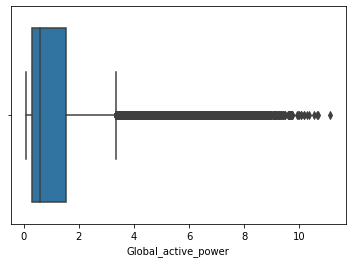

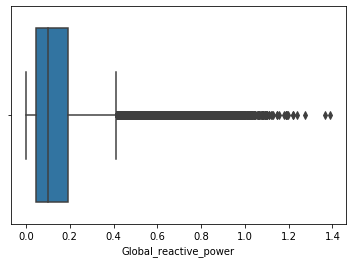

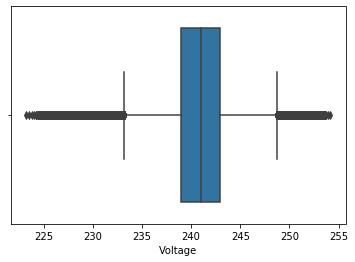

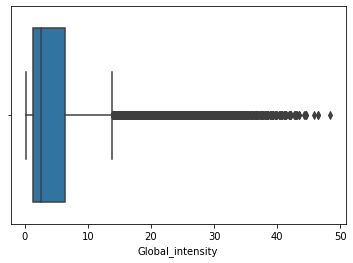

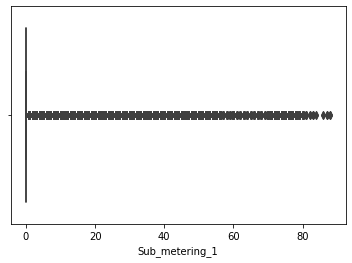

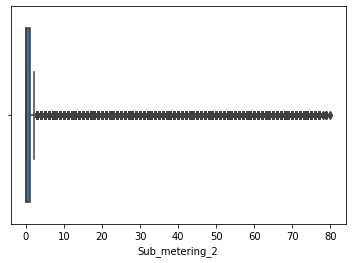

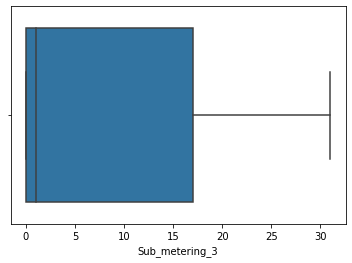

In [32]:
for j in range(2, electricidad_df.shape[1]):
    plt.figure()
    sns.boxplot(electricidad_df.iloc[:, j])
    plt.show()

Dado el plot de arriba, lo usaría solamente en 2 a 6.

In [33]:
df_ = None
for col in electricidad_df.columns[2:6]:
    if df_ is None:
        df_ = calcula_puntaje_RIC(electricidad_df, col)
        
    else:
        df_ = calcula_puntaje_RIC(df_, col)

,Global_active_power
q1,0.308
q3,1.528
RIC,1.220


,Global_reactive_power
q1,0.048
q3,0.194
RIC,0.146


,Voltage
q1,238.99
q3,242.89
RIC,3.90


,Global_intensity
q1,1.4
q3,6.4
RIC,5.0


In [34]:
display(df_)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,PRIC_Global_active_power,PRIC_Global_reactive_power,PRIC_Voltage,PRIC_Global_intensity
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2.203279,1.534247,1.064103,2.40
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,3.140984,1.657534,1.374359,3.32
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,3.152459,2.082192,1.461538,3.32
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,3.163934,2.109589,1.346154,3.32
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,1.752459,2.287671,0.848718,1.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,0.000000,0.328767,0.000000,0.00
2075255,26/11/2010,20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,0.000000,0.328767,0.000000,0.00
2075256,26/11/2010,21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,0.000000,0.328767,0.000000,0.00
2075257,26/11/2010,21:01:00,0.934,0.000,239.70,3.8,0.0,0.0,0.0,0.000000,0.328767,0.000000,0.00


## STD
[El notebook de kaggle más votado](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python): interés especial en la sección **Out Liars!** se usa un criterio de std  

El dataset ya está descargado en:

In [35]:
pd.read_csv('data_kaggle/house-prices-advanced-regression-techniques/train.csv')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


# Prueba de hipótesis: regresión sobre los precios de la vivienda
[El notebook de kaggle más votado](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python): interés especial en la sección 5 donde se analizan los supuestos más importantes de regresión lineal ... esto podría ser un marco para la prueba de hipótesis

# Métodos árboles
para llenar datos faltantes.